In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
import pandas as pd
import os 
import matplotlib.pyplot as plt
import math
import random
import torch.nn.functional as F

In [2]:
words=open('names.txt').read().splitlines()
chars=sorted(list(set(''.join(words))))
s_to_i={s:i+1 for i,s in enumerate(chars) }
s_to_i['.']=0
i_to_s={i:s for s,i in s_to_i.items()}
vocab_size=len(i_to_s)
s_to_i

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [164]:
def build_dataset(words):
    context_length=3
    x,y=[],[]
    for w in words:
        # print(w)
        context=[0]*context_length
        for ch in w+'.':
            idx=s_to_i[ch]
            x.append(context)
            y.append(idx)
            # print(''.join(i_to_s[i] for i in context),'--->',i_to_s[idx])
            context=context[1:]+[idx]
    x=torch.tensor(x)
    y=torch.tensor(y)
    print(x.shape,y.shape)
    return x,y


random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

x_train,y_train=build_dataset(words[:n1])
x_val,y_val=build_dataset(words[n1:n2])
x_test,y_test=build_dataset(words[n2:])


torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [184]:
# hyperparameters 
batch_size=64
emb_space=10
context_length=3
x_view=x_train.shape[1]*emb_space
h_units=200

#main model 
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,emb_space),generator=g)
w1=torch.randn((x_view,h_units),generator=g)*((5/3)/(30**0.5))
# b1=torch.randn((h_units),generator=g)*0.01
w2=torch.randn((h_units,vocab_size),generator=g)*0.01
b2=torch.randn((vocab_size),generator=g)*0
bngain=torch.ones((1,h_units))
bnbais=torch.zeros((1,h_units))
parameters=[C,w1,w2,b1,b2,bnbais,bngain]

lossi=[]
steps=[]
lri=[]
lrex=[]

for p in parameters:
    p.requires_grad=True
sum(p.nelement() for p in parameters)


12297

In [185]:
max_steps=200000
for i in range(max_steps):
    #minibatch construct
    ix=torch.randint(0,x_train.shape[0],(batch_size,)) 
    #foward pass
    emb=C[x_train[ix]]
    z=emb.view(emb.shape[0],x_view) @ w1
    z=bngain*((z-z.mean(0,keepdim=True))/z.std(0,keepdim=True)) + bnbais
    h= torch.tanh(z)
    logits=(h @ w2)+ b2 
    loss=F.cross_entropy(logits,y_train[ix])
    # if i%1000==0:
    #     print(loss.item())
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    lr=0.1 if i<100000 else 0.01
    for p in parameters:
            p.data+=-lr*p.grad

     # track stats
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    steps.append(i)
    lossi.append(loss.log10().item())


      0/ 200000 : 3.3117
  10000/ 200000 : 2.0763
  20000/ 200000 : 2.1737
  30000/ 200000 : 2.3763
  40000/ 200000 : 2.4341
  50000/ 200000 : 2.2094
  60000/ 200000 : 2.3086
  70000/ 200000 : 2.2440
  80000/ 200000 : 2.2127
  90000/ 200000 : 2.2554
 100000/ 200000 : 2.0052
 110000/ 200000 : 2.2912
 120000/ 200000 : 2.0091
 130000/ 200000 : 1.9353
 140000/ 200000 : 1.8592
 150000/ 200000 : 1.9983
 160000/ 200000 : 1.8813
 170000/ 200000 : 2.2980
 180000/ 200000 : 2.1140
 190000/ 200000 : 2.1140


In [157]:
logits

tensor([[ 5.4438e+00,  5.4223e+00, -5.0198e+00,  ..., -4.1012e+00,
          2.6485e+00, -1.0764e+00],
        [-3.8058e+00, -3.9410e-01, -3.5695e-03,  ...,  6.8003e-01,
          2.2550e+00,  1.1461e+00],
        [ 3.1262e+00,  1.8643e+00,  4.7600e-01,  ...,  5.2486e-01,
          8.4472e-02,  7.5360e-01],
        ...,
        [-3.0090e+00,  6.0966e+00, -4.2851e+00,  ..., -4.2593e+00,
          3.5527e+00, -2.3648e-01],
        [-3.4169e+00,  5.0294e+00, -3.2020e+00,  ..., -5.8573e+00,
          2.2935e+00, -1.4817e+00],
        [-8.7084e-01,  1.1604e+00, -2.8498e-01,  ..., -8.5744e-01,
         -2.7264e-02, -5.6314e-02]], grad_fn=<AddBackward0>)

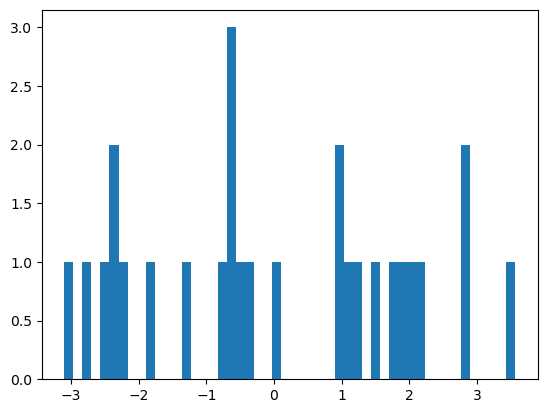

In [186]:
plt.hist(logits[0].detach().numpy(),bins=50);

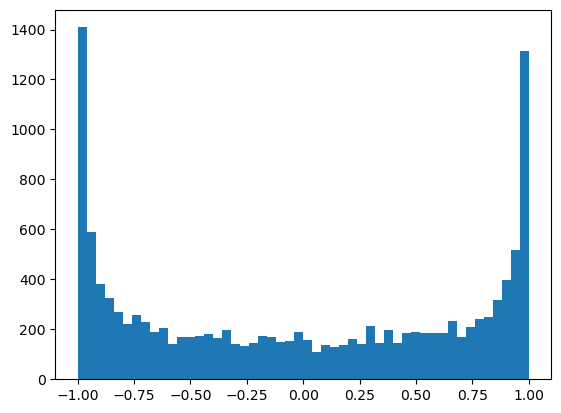

In [187]:
plt.hist(h.view(-1).tolist(),bins=50); # all values are mostly 1 or -1 

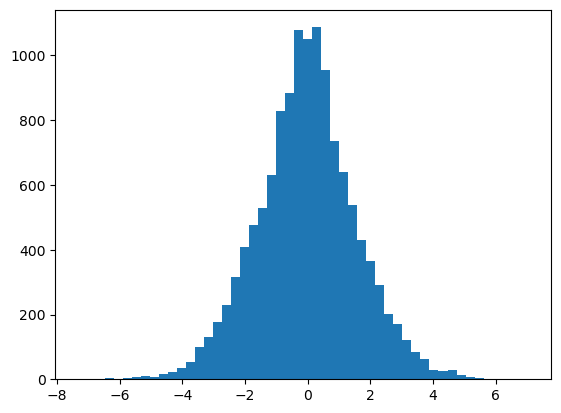

In [188]:
plt.hist(z.view(-1).tolist(),bins=50); #thus are z distribution is very broad all values tend to go to -1 or 1 after tanh()

Text(0, 0.5, 'the sequences in batch of 64')

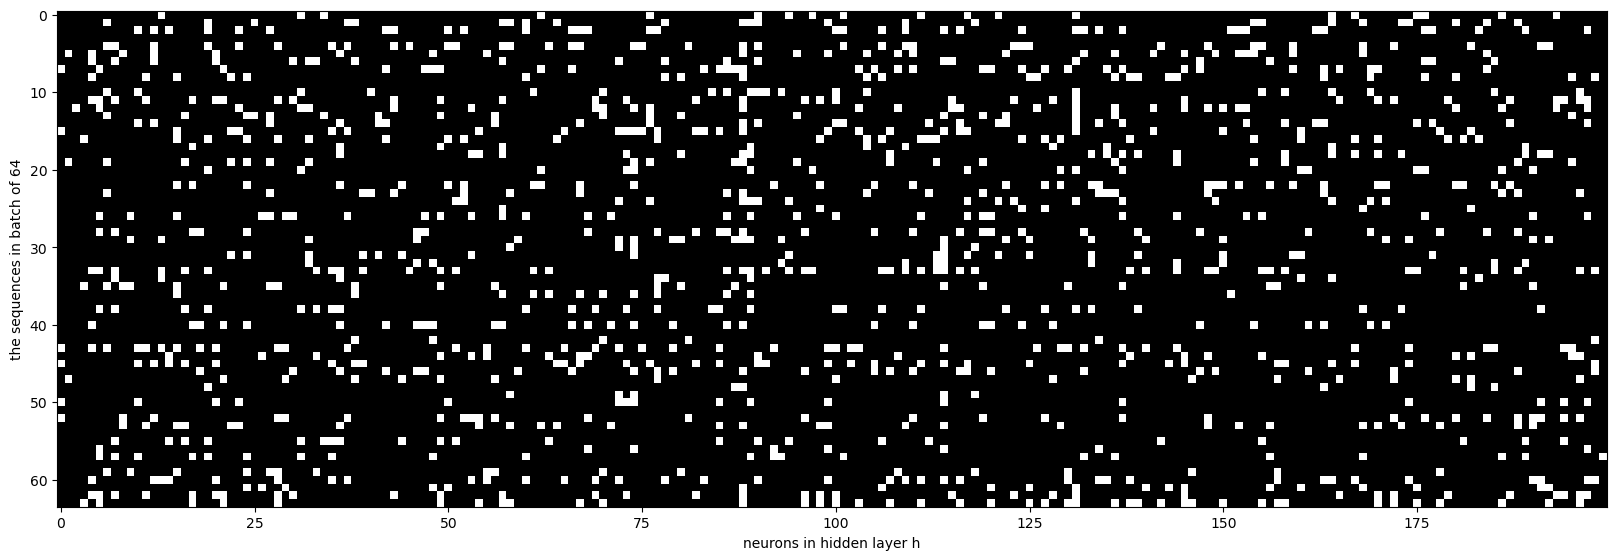

In [189]:
plt.figure(figsize=(20,20))
plt.imshow(h.abs()>0.99, cmap='gray',interpolation='nearest');
plt.xlabel('neurons in hidden layer h')
plt.ylabel('the sequences in batch of 64')


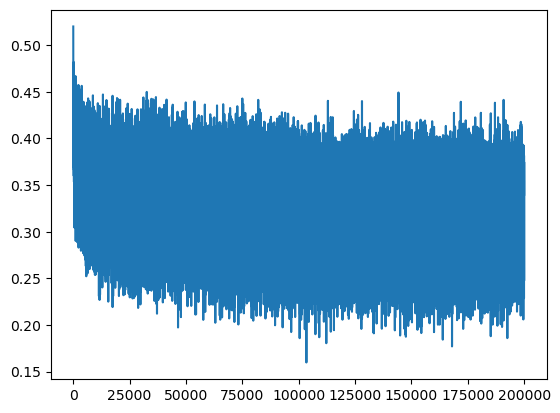

In [190]:
plt.plot(steps,lossi)

In [201]:
# calibrating batchnorm at the end of training 
with torch.no_grad():
    emb=C[x_train]
    z=emb.view(emb.shape[0],x_view) @ w1 + b1 
    bnmean=z.mean(0,keepdim=True)
    bnstd=z.std(0,keepdim=True)
    

In [210]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train':(x_train,y_train),
        'val':(x_val,y_val),
        'test':(x_test,y_test)
        }[split]
    
    emb=C[x]
    z=emb.view(emb.shape[0],x_view) @ w1 
    z=bngain*((z-bnmean)/bnstd)+bnbais
    h= torch.tanh(z)
    logits=(h @ w2)+ b2
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.044041156768799
val 2.1014084815979004
test 2.1065852642059326


In [218]:
# sampling from the moodel 
g=torch.Generator().manual_seed(2147483647)
for i in range(20):
    out=[]
    context=[0]*context_length
    while True:
        emb=C[torch.tensor([context])] #(1,conntext_length,d)
        h= torch.tanh(emb.view(1,-1) @ w1 + b1 )
        logits=(h @ w2)+ b2
        probs=F.softmax(logits,dim=1)
        idx=torch.multinomial(probs,num_samples=1).item()
        context=context[1:]+[idx]
        out.append(idx)
        if idx==0:
            break
    # print(''.join(i_to_s[i] for i in out))
emb=C[torch.tensor([context])]

In [222]:
# sampling from the moodel 
g=torch.Generator().manual_seed(2147483647)
for i in range(20):
    out=[]
    context=[0]*context_length
    while True:
        emb=C[torch.tensor([context])] #(1,conntext_length,d)
        z=emb.view(1,-1) @ w1 
        z=bngain*((z-bnmean)/bnstd)+bnbais
        h= torch.tanh(z)
        logits=(h @ w2)+ b2
        probs=F.softmax(logits,dim=1)
        idx=torch.multinomial(probs,num_samples=1).item()
        context=context[1:]+[idx]
        out.append(idx)
        if idx==0:
            break
    print(''.join(i_to_s[i] for i in out))

saibenzee.
aafinnlee.
dakerlstotalle.
kaiyalli.
chaleam.
jonaharosiloselah.
krimet.
grianie.
elna.
dalains.
kalynn.
khanni.
kinzoel.
jovan.
osin.
kintery.
folanyn.
logen.
jontusiyah.
keni.


In [29]:
-torch.tensor(1/27.0).log()  # this should be are loss at initiallization but we got loss=26.5 at initialization thus are initialization is poor   

tensor(3.2958)

In [98]:
# 4-d example of the issue 
logits=torch.tensor([1.0,1.0,1.0,1.0])
# logits=torch.rand(4)
probs=torch.softmax(logits,dim=0)
loss=-probs[2].log()
probs,loss  

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

(array([0., 0., 0., 0., 0., 4., 0., 0., 0., 0.]),
 array([-0.25      , -0.15000001, -0.05      ,  0.05      ,  0.15000001,
         0.25      ,  0.34999999,  0.44999999,  0.55000001,  0.64999998,
         0.75      ]),
 <BarContainer object of 10 artists>)

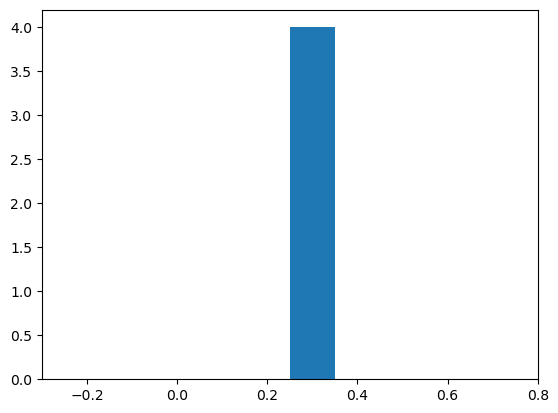

In [99]:
plt.hist(probs.squeeze().detach().numpy())